In [1]:
import torch
import torchvision
import PIL.Image
import os
import random

device = 'cuda'
dtype = torch.float16

compose = {
    'input':
    torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.ColorJitter(brightness=0.2,
                                           contrast=0.2,
                                           saturation=0.2,
                                           hue=0.05),
        torchvision.transforms.Resize(size=512, max_size=700),
    ]),
    'to_tensor':
    torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5], [0.5])
    ]),
    'to_tensor_encoder':
    torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
    ])
}

from diffusers import DDPMScheduler

scheduler_noise = DDPMScheduler(beta_end=0.012,
                                beta_schedule='scaled_linear',
                                beta_start=0.00085,
                                clip_sample=False,
                                steps_offset=1)

compose, scheduler_noise

({'input': Compose(
      RandomHorizontalFlip(p=0.5)
      RandomVerticalFlip(p=0.5)
      ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=[-0.05, 0.05])
      Resize(size=512, interpolation=bilinear, max_size=700, antialias=None)
  ),
  'to_tensor': Compose(
      ToTensor()
      Normalize(mean=[0.5], std=[0.5])
  ),
  'to_tensor_encoder': Compose(
      ToTensor()
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  )},
 DDPMScheduler {
   "_class_name": "DDPMScheduler",
   "_diffusers_version": "0.30.1",
   "beta_end": 0.012,
   "beta_schedule": "scaled_linear",
   "beta_start": 0.00085,
   "clip_sample": false,
   "clip_sample_range": 1.0,
   "dynamic_thresholding_ratio": 0.995,
   "num_train_timesteps": 1000,
   "prediction_type": "epsilon",
   "rescale_betas_zero_snr": false,
   "sample_max_value": 1.0,
   "steps_offset": 1,
   "thresholding": false,
   "timestep_spacing": "leading",
   "trained_betas": null,
   "variance_t

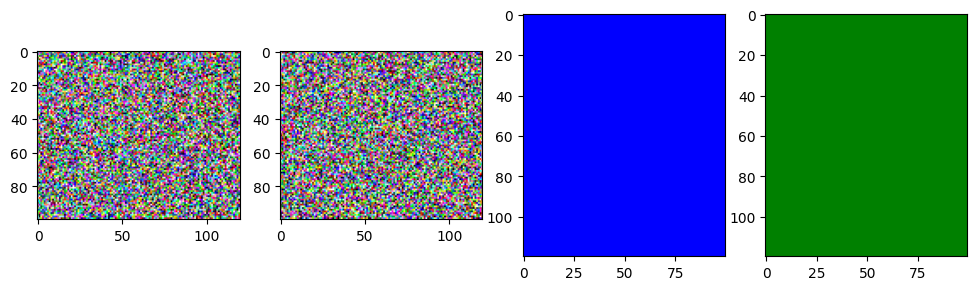

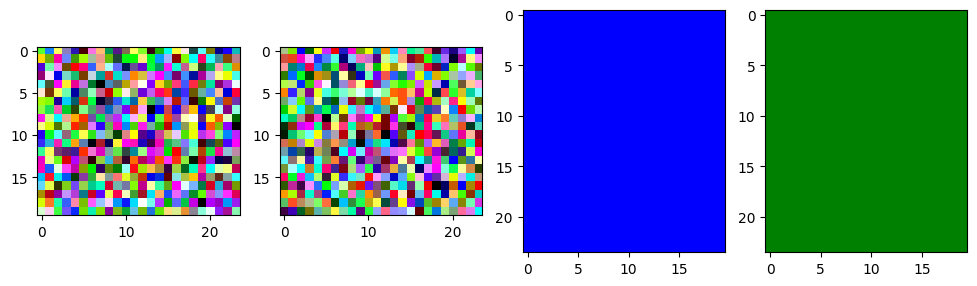

In [2]:
def show_grid(images, scala=True):
    if scala:
        show_grid(images, scala=False)

    from matplotlib import pyplot as plt
    import numpy as np

    names = [''] * 4
    if isinstance(images, dict):
        names = list(images.keys())
        images = list(images.values())

    def tensor_to_image(x):
        if len(x.shape) == 4:
            x = x[0]

        x = x * 0.5 + 0.5
        x = (x * 255).clip(0, 255)
        x = x.permute(1, 2, 0).detach().cpu().numpy().astype('uint8')
        return PIL.Image.fromarray(x)

    plt.figure(figsize=(12, 5))
    for i, image in enumerate(images):
        if isinstance(image, torch.Tensor):
            image = tensor_to_image(image)

        image = np.array(image)

        if scala:
            h, w, _ = image.shape
            image = image[int(h * 0.4):int(h * 0.6), int(w * 0.4):int(w * 0.6)]

        plt.subplot(1, 4, i + 1)
        plt.title(names[i])
        plt.imshow(image)

    plt.show()


show_grid([
    torch.randn(1, 3, 100, 120),
    torch.randn(1, 3, 100, 120),
    PIL.Image.new(mode='RGB', size=[100, 120], color='blue'),
    PIL.Image.new(mode='RGB', size=[100, 120], color='green')
])

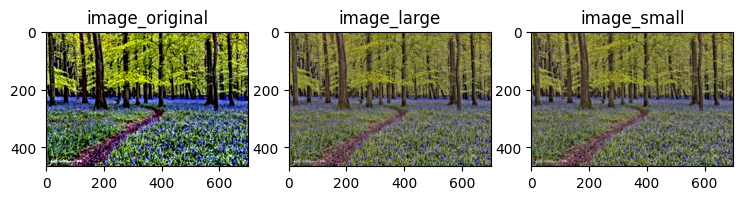

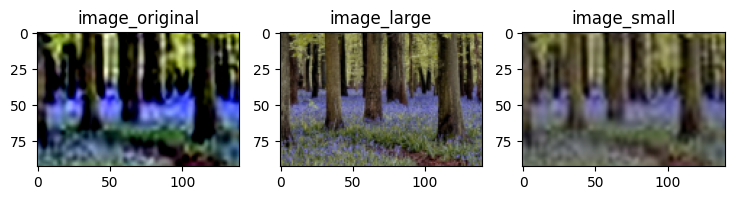

(54278,
 {'image_original': torch.Size([1, 3, 499, 700]),
  'image_large': torch.Size([1, 3, 499, 700]),
  'image_small': torch.Size([1, 3, 499, 700])})

In [3]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self):

        def get_paths(root):
            if os.path.isfile(root):
                return [root]

            path = []
            for i in os.listdir(root):
                i = os.path.join(root, i)
                path.extend(get_paths(i))
            return path

        self.path = get_paths('dataset/image')

    def __len__(self):
        return len(self.path)

    def __getitem__(self, i):
        image = self.path[i]

        try:
            image = PIL.Image.open(image).convert('RGB')
            assert min(image.size) >= 100
        except:
            print('error', image)
            return self.__getitem__(random.randint(0, len(self) - 1))

        image_large = compose['input'](image)

        def squeeze(image, ratio, rs):
            size = image.size
            image = image.resize([int(i * ratio) for i in size], rs)
            path = 'dataset/image/temp.jpg'
            image.save(path)
            image = PIL.Image.open(path)
            return image.resize(size, rs)

        ratio, rs = random.uniform(0.25, 0.5), random.randint(0, 5)
        image_small = squeeze(image_large, ratio, rs)
        image_original = image_small

        image_original = compose['to_tensor_encoder'](image_original).to(
            device, dtype)
        image_large = compose['to_tensor'](image_large).to(device, dtype)
        image_small = compose['to_tensor'](image_small).to(device, dtype)

        return {
            'image_original': image_original,
            'image_large': image_large,
            'image_small': image_small
        }


loader = torch.utils.data.DataLoader(Dataset(),
                                     batch_size=1,
                                     shuffle=True,
                                     collate_fn=None)

show_grid(next(iter(loader)))

len(loader), {k: v.shape for k, v in next(iter(loader)).items()}

In [4]:
from accelerate import Accelerator
%run 1.vae.ipynb
%run 2.unet.ipynb
%run 3.encoder.ipynb
%run 4.controlnet.ipynb

#controlnet.load_state_dict(torch.load('model/controlnet_1730681254'))

vae.requires_grad_(False).to(device, dtype)
unet.requires_grad_(False).to(device, dtype)
encoder.requires_grad_(False).to(device, dtype)
controlnet.train()

optimizer = torch.optim.AdamW(controlnet.parameters(),
                              lr=1e-5,
                              betas=(0.9, 0.999),
                              weight_decay=0.01,
                              eps=1e-8)
schduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                      T_max=1000,
                                                      eta_min=1e-6)

accelerator = Accelerator(gradient_accumulation_steps=1,
                          mixed_precision='fp16')

controlnet, optimizer, loader, schduler = accelerator.prepare(
    controlnet, optimizer, loader, schduler)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


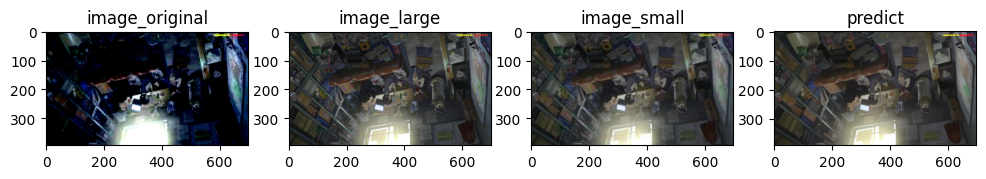

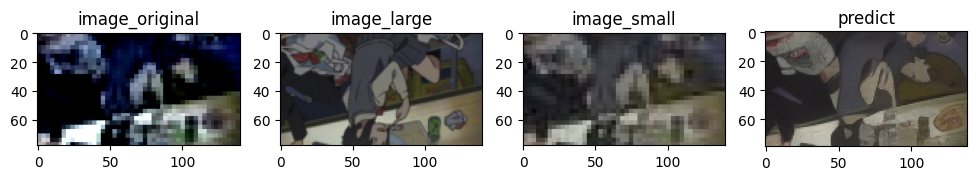

In [5]:
@torch.no_grad()
def test():
    scheduler_noise.set_timesteps(20)

    data = next(iter(loader))
    q, _ = vae.encode(data['image_small'])
    q = torch.randn_like(q)

    kv = encoder(data['image_original'])

    for timestep in scheduler_noise.timesteps:
        controlnet_down, controlnet_mid = controlnet(
            q=q, kv=kv, timestep=timestep, controlnet_cond=data['image_small'])

        kv = kv.to(device, dtype)
        controlnet_mid = controlnet_mid.to(device, dtype)
        controlnet_down = [i.to(device, dtype) for i in controlnet_down]

        pred_noise = unet(q=q,
                          kv=kv,
                          timestep=timestep,
                          controlnet_down=controlnet_down,
                          controlnet_mid=controlnet_mid)

        q = scheduler_noise.step(pred_noise, timestep, q, return_dict=False)[0]

    image = vae.decode(q / 0.18215)

    data['predict'] = image
    show_grid(data)

    scheduler_noise.set_timesteps(1000)


test()

0 0 0.24629637598991394 9.999977793408363e-06 True


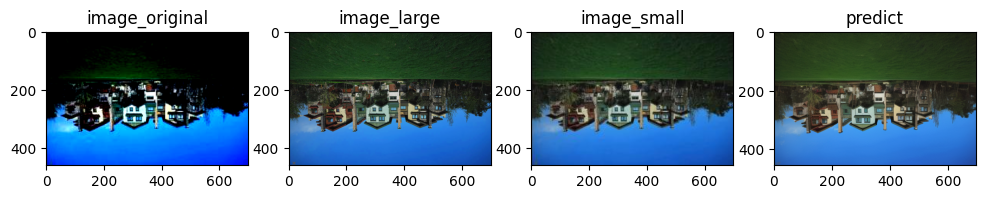

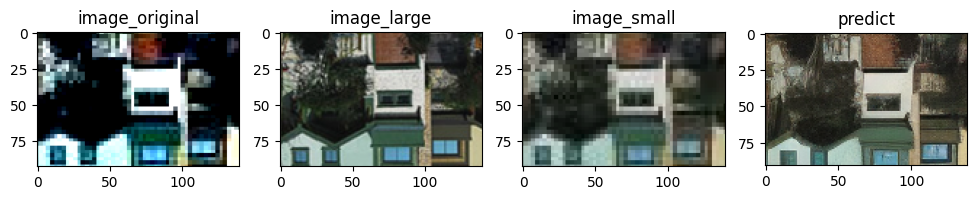

/root/miniconda3/envs/cuda117/lib/python3.10/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (160707647 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


error ../code6/dataset/image/5万款图片素材/室内装修背景合集/室内装修背景图系列 (4)/东海徽园/东海二套/施工图/钢结构.dwg


/root/miniconda3/envs/cuda117/lib/python3.10/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (120000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


error ../code6/dataset/image/5万款图片素材/室内装修背景合集/室内装修背景图系列 (4)/东海徽园/原始建筑图纸/详图.dwg
0 500 0.04142627492547035 5.485862856313563e-06 True


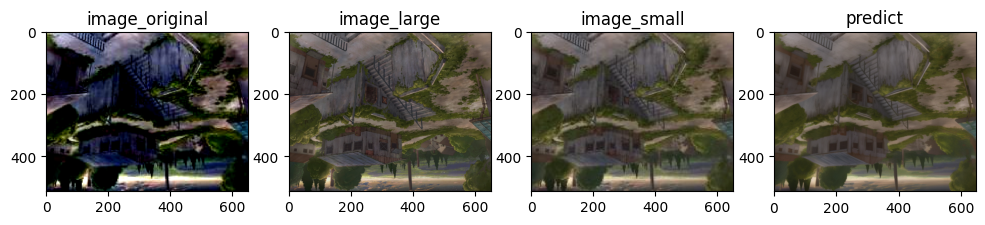

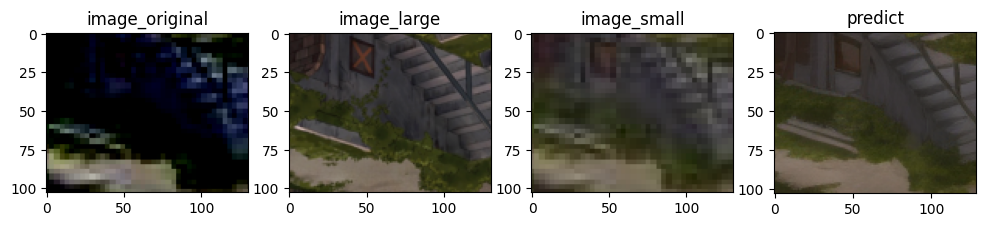


KeyboardInterrupt



In [6]:
for epoch in range(99999999):
    for step, data in enumerate(loader):
        with accelerator.accumulate(controlnet):
            mean, std = vae.encode(data['image_large'])

            q = (mean + std * torch.randn_like(mean)) * 0.18215

            noise = torch.randn_like(q)
            timestep = torch.randint(0, 1000, [1], device=device).long()

            q = scheduler_noise.add_noise(q, noise, timestep)
            kv = encoder(data['image_original'])

            controlnet_down, controlnet_mid = controlnet(
                q=q,
                kv=kv,
                timestep=timestep,
                controlnet_cond=data['image_small'])

            kv = kv.to(device, dtype)
            controlnet_mid = controlnet_mid.to(device, dtype)
            controlnet_down = [i.to(device, dtype) for i in controlnet_down]

            pred_noise = unet(q=q,
                              kv=kv,
                              timestep=timestep,
                              controlnet_down=controlnet_down,
                              controlnet_mid=controlnet_mid)

            loss = torch.nn.functional.mse_loss(pred_noise.float(),
                                                noise.float(),
                                                reduction='mean')

            accelerator.backward(loss)
            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(controlnet.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad(set_to_none=False)
            schduler.step()

        if step % 500 == 0:
            print(epoch, step, loss.item(), optimizer.param_groups[0]['lr'],
                  accelerator.sync_gradients)
            test()

In [7]:
import time

torch.save(controlnet.state_dict(), 'model/controlnet_%d' % time.time())